In [1]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent

In [2]:
#directories
dataset_name = 'mountain_dataset'
dataset_dir = f'datasets/{dataset_name}'
output_dir ="output"
g_matrix_filename = f"G_{dataset_name}.npy" #Name of the file where matrix G will be saved
gamma_filename = f"gamma_{dataset_name}.npy"
weight_matrix_filename = f"w_{dataset_name}.npy"

In [3]:
#This function loads images from a specific folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

In [4]:
#Load images from the folder
imgs = load_images_from_folder(dataset_dir)
n = len(imgs) #Number of images

#Load G matrix
G = np.load(os.path.join(output_dir,g_matrix_filename))
gamma = np.load(os.path.join(output_dir,gamma_filename))
weight_matrix = np.load(os.path.join(output_dir,weight_matrix_filename))

In [5]:
def buildAndPrintGraph(gamma, weight_matrix):
    G=nx.Graph()
    for i in range(0,n):
        G.add_node(i,image = imgs[i])
    for i in range(n): 
         for j in range(n): 
            if gamma[i,j] == 1:
                G.add_edge(i,j, weight=weight_matrix[i,j]) 
    pos=nx.circular_layout(G)
    fig=plt.figure(figsize=(15,15))
    ax=plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw(G,pos,ax=ax, width = 3, node_size=900,with_labels = True, edgecolors='red', node_color='lightgray')
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    trans=ax.transData.transform
    trans2=fig.transFigure.inverted().transform
    piesize=0.08 # this is the image size
    p2=piesize/0.9 #this is the image center
    for g in G:
        xx,yy=trans(pos[g]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[g]['image'])
        a.axis('off')
    ax.axis('off')
    plt.show()
    return G

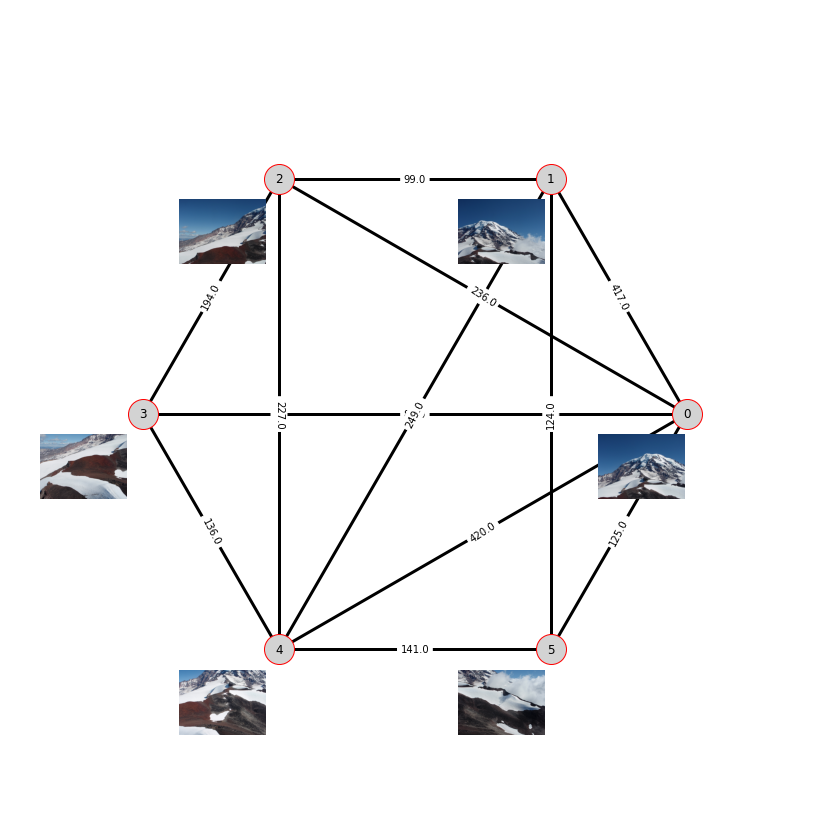

In [6]:
graph = buildAndPrintGraph(gamma = gamma, weight_matrix = weight_matrix)

In [7]:
def get_clusters(gamma, weight_matrix):
    distances = weight_matrix.copy()
    maxx = np.max(distances)
    mask = distances != 0
    distances[mask] = maxx / distances[mask]
    
    clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None,affinity="precomputed",connectivity=gamma,linkage="average").fit(distances)
    linkage_matrix = get_linkage_matrix(clustering)
    den = dendrogram(linkage_matrix, truncate_mode=None) # truncate_mode="level", p=3)
    k = len(list(dict.fromkeys(den["leaves_color_list"]))) + max(den["leaves_color_list"].count('C0') - 1, 0 )
    cluster = fcluster(linkage_matrix, 2, criterion='maxclust')

    return cluster-1

In [8]:
def get_linkage_matrix(model):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix 

array([1, 1, 0, 0, 1, 1], dtype=int32)

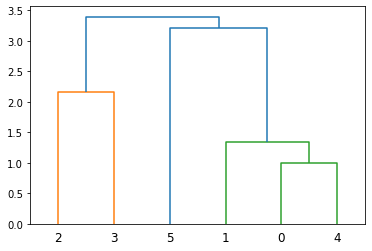

In [9]:
cluster = get_clusters(gamma,weight_matrix)
cluster

In [10]:
def split_Matrices(G,gamma, cluster):
    new_matrices = list()
    for c in np.unique(cluster):
        indexes = cluster==c
        expanded_indexes =np.array([], dtype = bool)
        for i in indexes:
            expanded_indexes = np.concatenate([expanded_indexes,[i]*3])
        subgraph_gamma = gamma[np.ix_(indexes, indexes)]
        new_matrices.append({"c":c,
                             "H":G[np.ix_(expanded_indexes, expanded_indexes)],
                             "gamma": subgraph_gamma,
                            "endpoint":np.argmax(np.sum(subgraph_gamma, axis=1))})
    return new_matrices    

In [11]:
new_matrices = split_Matrices(G,gamma,cluster)
new_matrices

[{'c': 0,
  'H': array([[-4.        , -0.        , -0.        ,  1.0365815 , -0.09561346,
          -0.1059797 ],
         [-0.        , -4.        , -0.        ,  0.0387601 ,  0.87367152,
           0.3130103 ],
         [-0.        , -0.        , -4.        ,  0.08390186, -0.23670999,
           1.0083899 ],
         [ 0.95561713,  0.121911  ,  0.06227131, -3.        , -0.        ,
          -0.        ],
         [-0.01270612,  1.05408166, -0.32859012, -0.        , -3.        ,
          -0.        ],
         [-0.08174396,  0.23785476,  0.90881935, -0.        , -0.        ,
          -3.        ]]),
  'gamma': array([[1., 1.],
         [1., 1.]]),
  'endpoint': 0},
 {'c': 1,
  'H': array([[-5.00000000e+00, -0.00000000e+00, -0.00000000e+00,
           8.55203239e-01,  4.38837870e-02,  3.23994676e-01,
           1.01739549e+00, -1.15586859e-01, -3.30531184e-02,
           6.55458957e-01, -2.04883910e-01,  7.13086867e-01],
         [-0.00000000e+00, -5.00000000e+00, -0.00000000e+00,
 

In [12]:
# This function allows to stitch images together
def stitch_images(U, imgs, idx_ref, num, idxs=None, beautify=True):
    if not idxs:
        idxs = list(range(num))
    
    #Compute the homography of each image w.r.t. the reference one
    H = [np.dot(U[i],np.linalg.inv(U[idx_ref])) for i in range(num)]
    
    rescale = 1./np.max(imgs[idx_ref].shape)
    T_norm = np.diag([rescale,rescale,1])
    H_norm=H
    H = [ np.linalg.inv(T_norm) @ h @ T_norm  for h in H]
    
    min_x = 0
    min_y = 0
    max_x = 0
    max_y = 0
    
    #For each image
    for i in idxs:
        
         ## translate
        (Height, Width, _) = imgs[i].shape

        # Taking the matrix of initial coordinates of the corners of the secondary image
        # Stored in the following format: [[x1, x2, x3, x4], [y1, y2, y3, y4], [1, 1, 1, 1]]
        # Where (xt, yt) is the coordinate of the i th corner of the image. 
        InitialMatrix = np.array([[0, Width - 1, Width - 1, 0],
                                  [0, 0, Height - 1, Height - 1],
                                  [1, 1, 1, 1]])

        # Finding the final coordinates of the corners of the image after transformation.
        # NOTE: Here, the coordinates of the corners of the frame may go out of the 
        # frame(negative values). We will correct this afterwards by updating the 
        # homography matrix accordingly.
        FinalMatrix = np.dot(np.linalg.inv(H[i]), InitialMatrix)

        [x, y, c] = FinalMatrix
        x = np.divide(x, c)
        y = np.divide(y, c)

        c_min_x = min(x)
        c_min_y = min(y)
        c_max_x = max(x)
        c_max_y = max(y)
        
        if c_min_x < min_x:
            min_x = c_min_x
            
        if c_min_y < min_y:
            min_y = c_min_y
            
        if c_max_x > max_x:
            max_x = c_max_x
            
        if c_max_y > max_y:
            max_y = c_max_y

            
    size =  [5000,10000] # y,x
    
    if beautify:
        t = [-min_x,-min_y]
        dy = int(min(max_y - min_y, size[0]))
        dx = int(min(max_x - min_x, size[1]))
        size = [dy,dx]
    else:
        t = [0,0]        
    print(t, size)
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate
    H_norm = [(hn @ T_norm @ np.linalg.inv(Ht) @  np.linalg.inv(T_norm)) for hn in H_norm]
    stitch = np.zeros(size + [3], dtype=np.uint8)
       
    #For each image
    for i in idxs:
        print(np.linalg.det(H[i]))
    
        # debug
        #print(x)
        #print(y)

        #H_proj = np.dot(H[i],Ht)

        #Apply the homography        
      #  img_proj = skimage.transform.warp(imgs[i], H[i],output_shape= size)
        img_proj = cv.warpPerspective(imgs[i], Ht @ np.linalg.inv(H[i]) , size[::-1])
        #plt.imshow(img_proj[:1000,:1000],),plt.show()
        
        
        
        #Use maximum as stitch operator (very simple stitching mechanism)
        stitch = np.maximum(stitch,img_proj)
   
    
    return H_norm, stitch

In [13]:
#This function splits a 3nx3n matrix into a set of 3x3 matrices
def get_states(x):
    x_small = x.transpose()
    res = [ x_small[:,i*3:(i+1)*3].transpose() for i in range(x_small.shape[1]//3)]
    return res

In [14]:
for matrices in new_matrices:
    zeta = np.sum(matrices["gamma"], axis=0)
    G_temp = np.copy(matrices["H"])
    for i in range(0,zeta.shape[0]):
        G_temp[3*i:3*(i+1),3*i:3*(i+1)] = np.eye(3,3)*(1-zeta[i])
    matrices["G"] = G_temp
    if(matrices["G"].shape != (3,3)):
        u,d,vh = np.linalg.svd(matrices["G"]) #Application of SVD to the G matrix
        v = vh.transpose() #Transpose matrix of right eigenvectors
        # Find the three right singular vectors associated
        # with the 3 smallest singular value (so the last 3 columns)
        u_hat = v[:,[-1,-2,-3]]
        U = get_states(u_hat) #Get the state of each node
        indexes = cluster==matrices["c"]
        imgs_slice = [imgs[i] for i in np.where(indexes)[0]]
        matrices["label"],matrices["img"] = stitch_images(U, imgs_slice, matrices["endpoint"], len(imgs_slice), beautify=True) #Stitch all the images
    else:
        matrices["img"] = imgs[np.where(cluster==matrices["c"])[0][0]]
        matrices["label"] = [np.eye(3)]

[110.43001364173537, 0] [601, 626]
0.9999999999999997
1.00000678500935
[73.61307951862624, 63.52199135571815] [935, 1353]
0.9999999999999998
0.9999565166240737
0.9999322374961814
0.9999123319024039


## Stitch images together

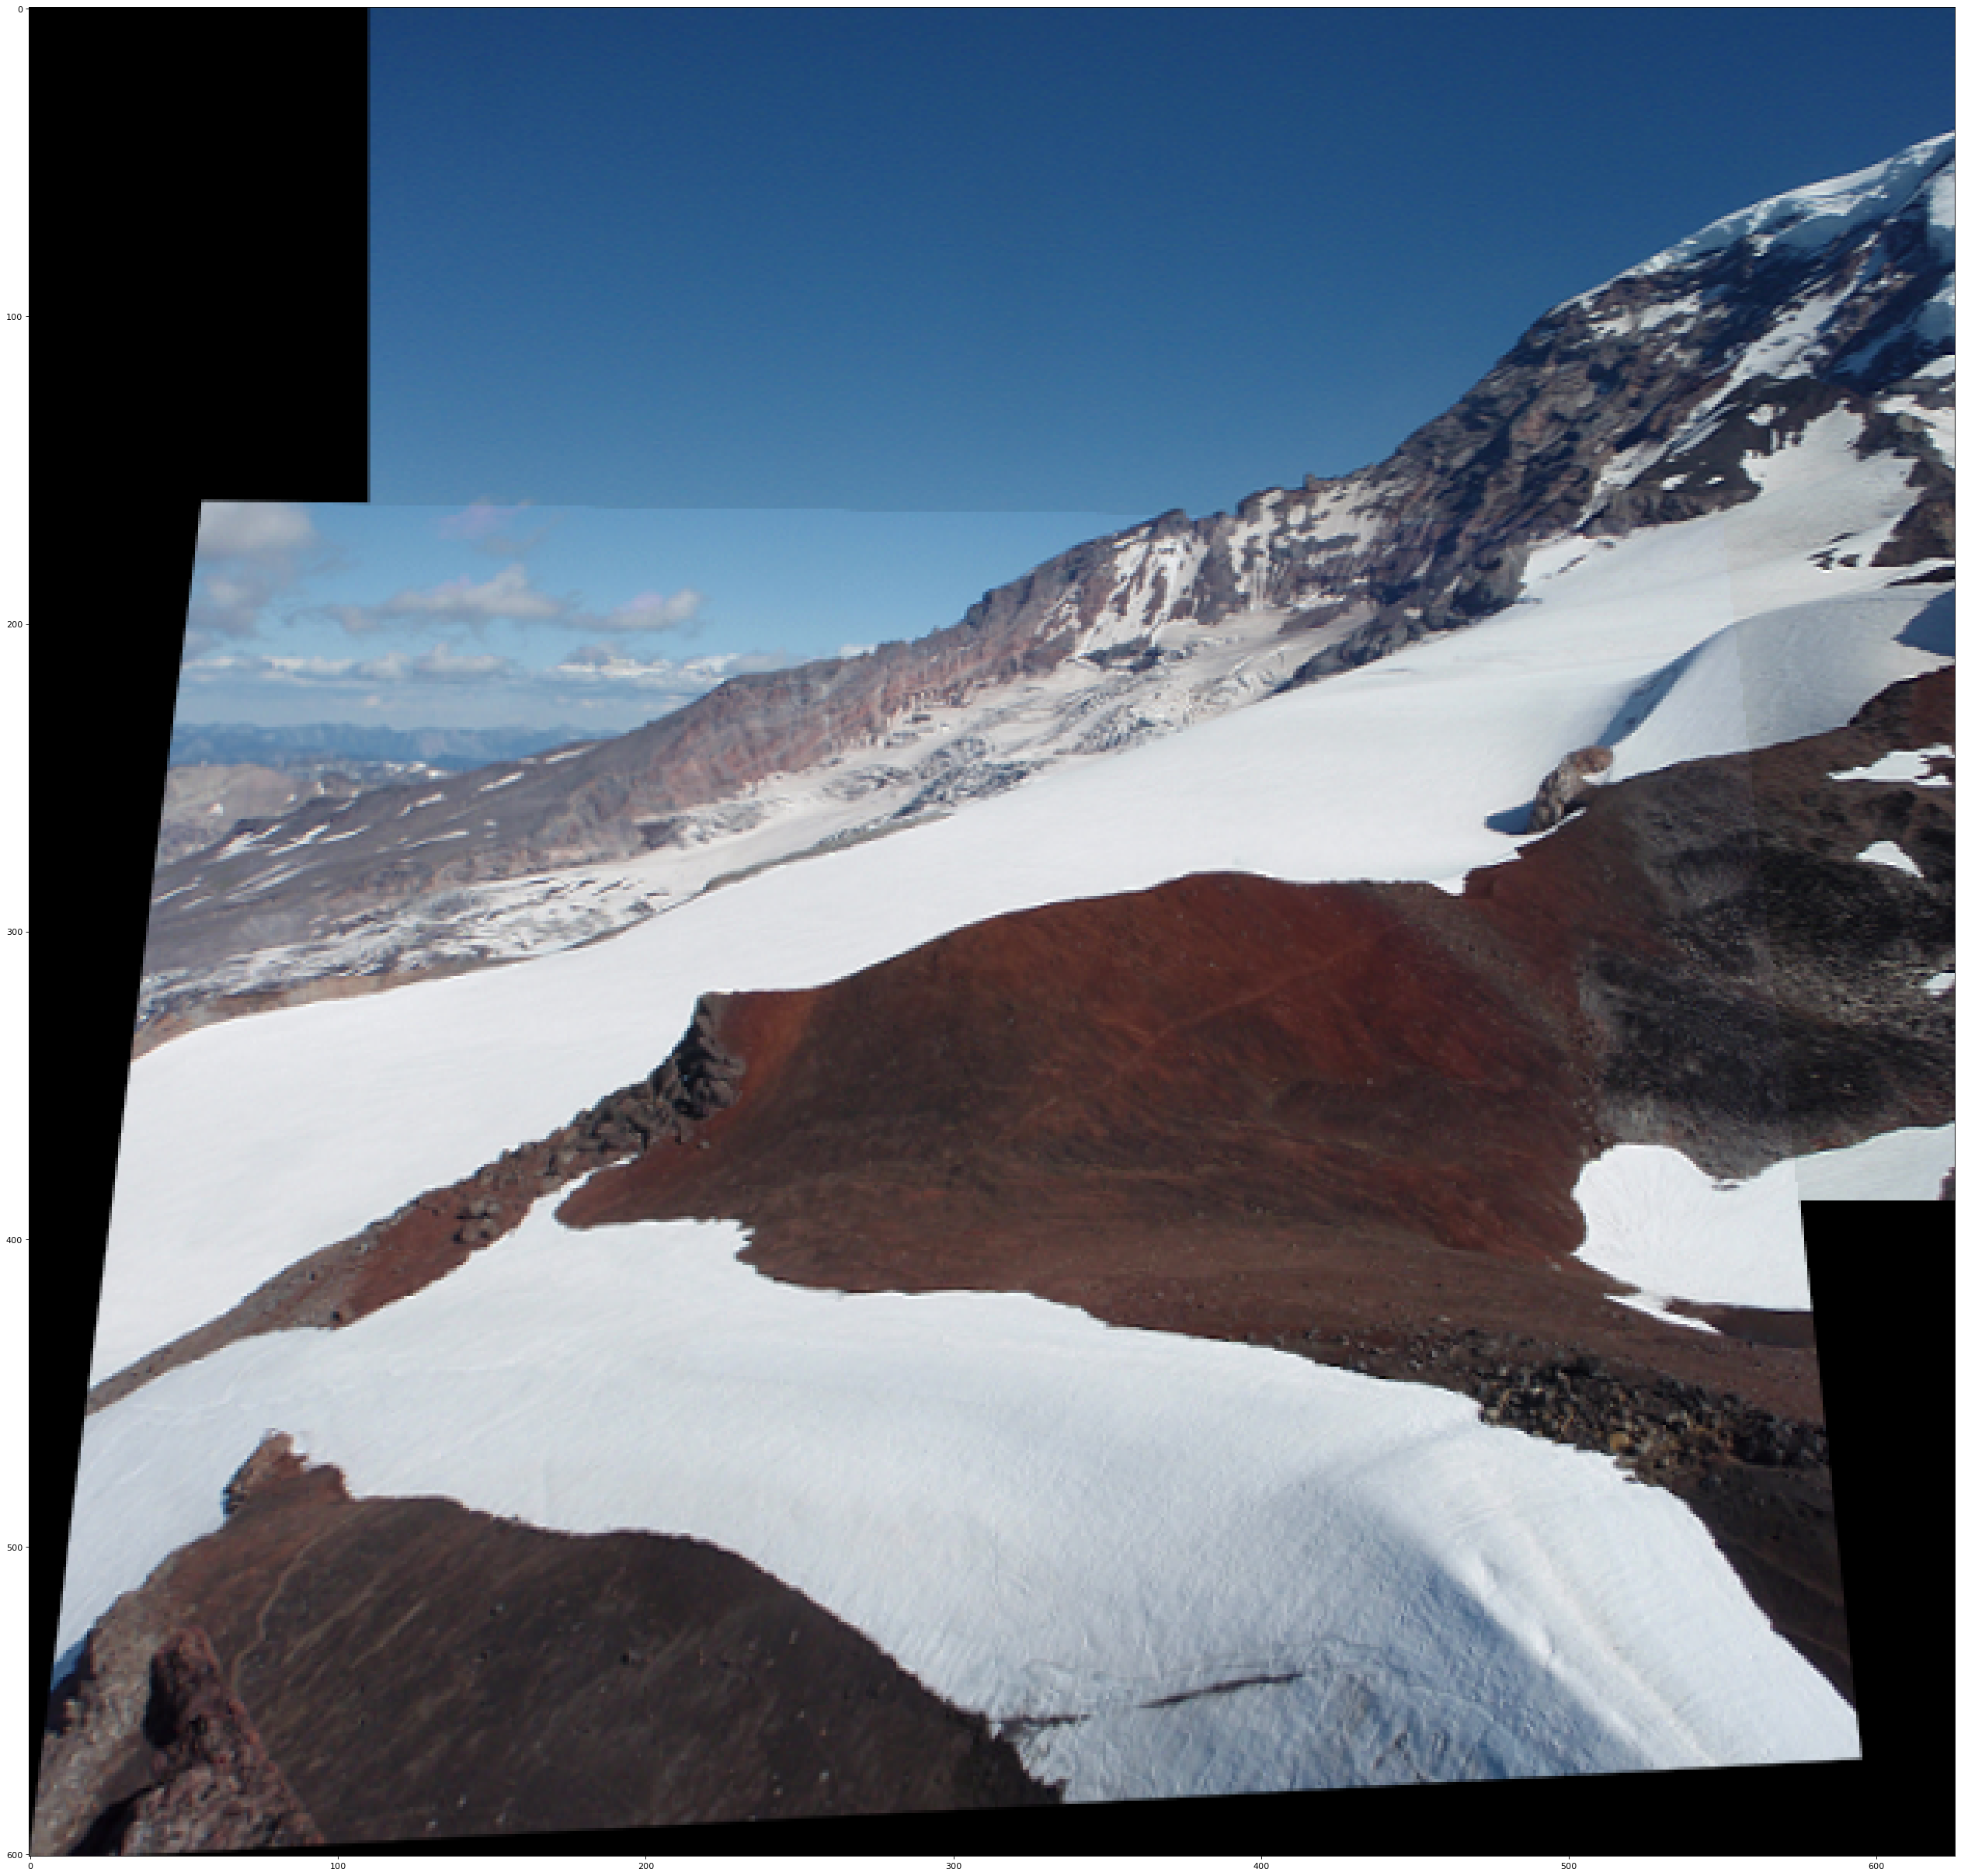

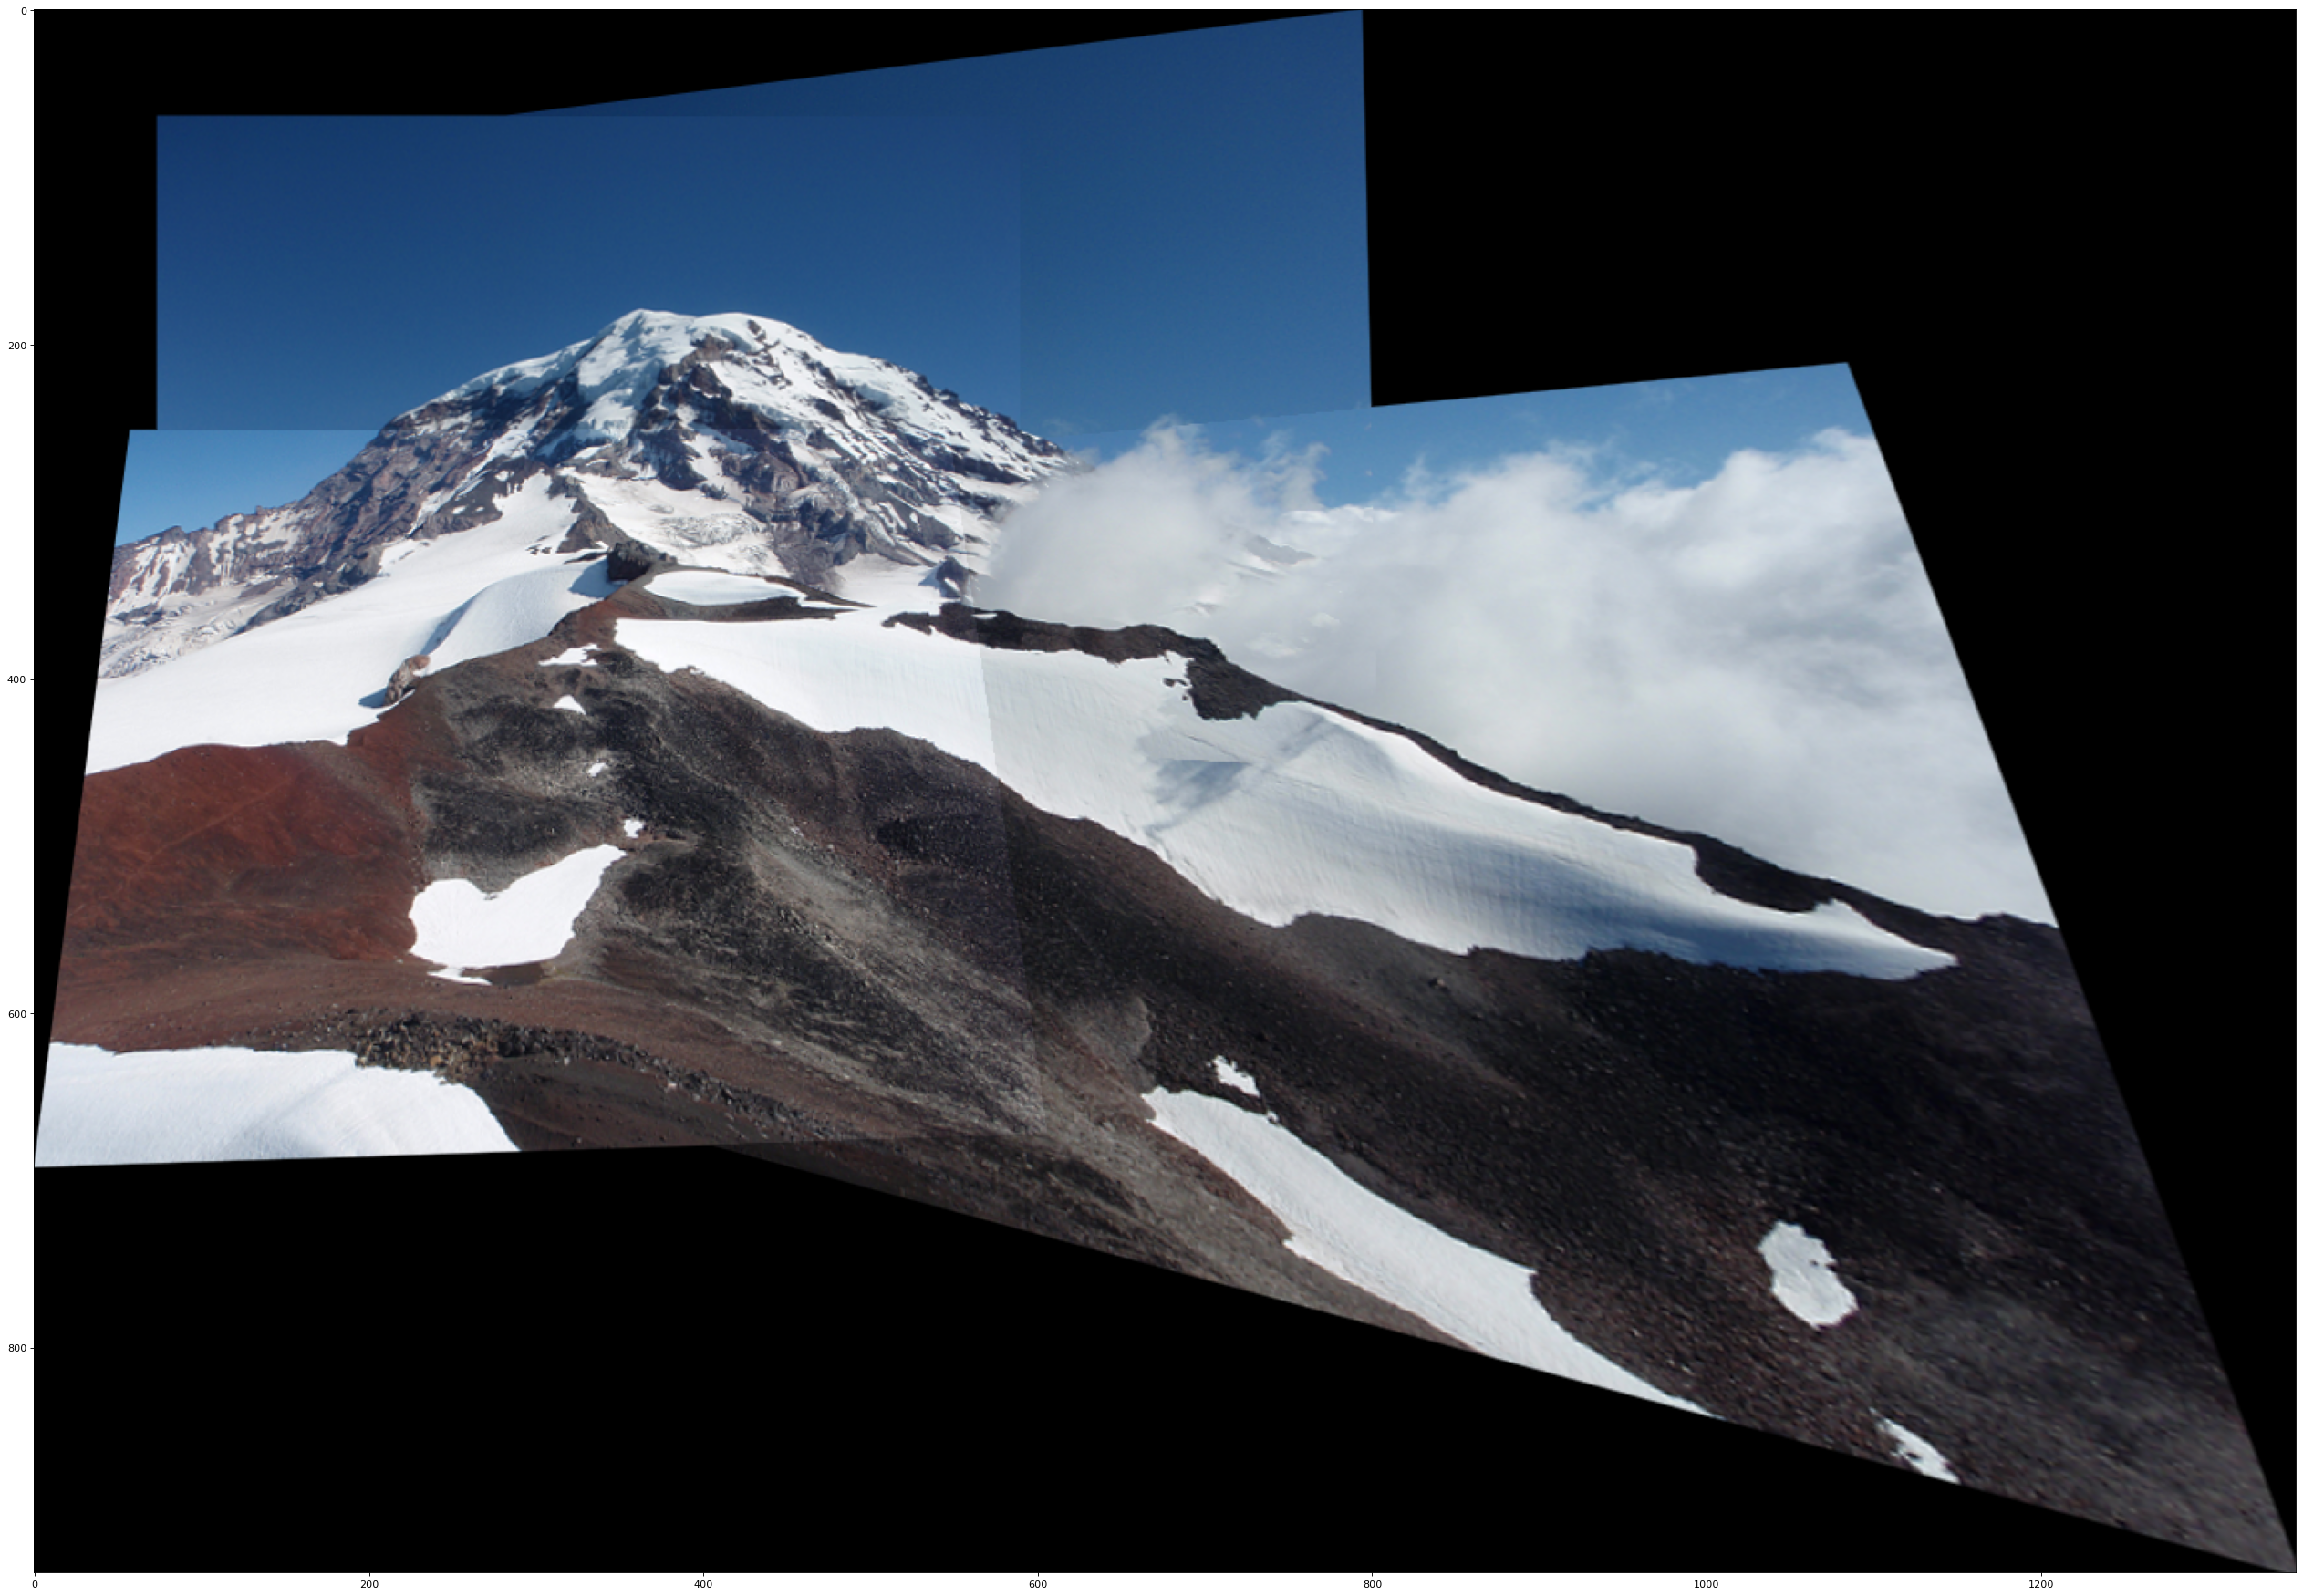

In [15]:
for matrices in new_matrices:
    figure(figsize=(40, 40), dpi=80)
    plt.imshow(matrices["img"],),plt.show() #Plot stitched image

In [16]:
patch_graph = dict()
adj_matrix = np.zeros([len(np.unique(cluster)),len(np.unique(cluster))], dtype=int)
for i in range(n):
    c1 = cluster[i]
    indexes = np.where(cluster==c1)[0]
    xi=new_matrices[c1]["label"][np.where(indexes==i)[0][0]]
    for j in range(n):
        c2 = cluster[j]
        if(c1!=c2): #different cluster
            if(gamma[i,j] != 0):
                if((c1, c2) not in patch_graph):
                    patch_graph[c1, c2] = list()
                adj_matrix[c1,c2]+=1
                indexes2 = np.where(cluster==c2)[0]
                xj=new_matrices[c2]["label"][np.where(indexes2==j)[0][0]]
                small_g = np.copy(G[3*j:3*(j+1), 3*i:3*(i+1)])
                patch_graph[c1,c2].append(np.linalg.inv(xj)@small_g@xi)
                if((np.where(indexes==i)[0][0])==new_matrices[c1]["endpoint"] and (np.where(indexes2==j)[0][0])==new_matrices[c2]["endpoint"]):
                    print(c1, c2, len(patch_graph[c1,c2]), i, j)
                    print(xi, xj)
                    

1 0 1 0 2
[[ 1.00000000e+00 -5.55111512e-17 -1.42385067e-01]
 [-4.16333634e-17  1.00000000e+00 -1.22866521e-01]
 [-2.08166817e-17  0.00000000e+00  1.00000000e+00]] [[ 1.00000000e+00  0.00000000e+00 -2.13597705e-01]
 [ 0.00000000e+00  1.00000000e+00 -2.77555756e-17]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
0 1 1 2 0
[[ 1.00000000e+00  0.00000000e+00 -2.13597705e-01]
 [ 0.00000000e+00  1.00000000e+00 -2.77555756e-17]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 1.00000000e+00 -5.55111512e-17 -1.42385067e-01]
 [-4.16333634e-17  1.00000000e+00 -1.22866521e-01]
 [-2.08166817e-17  0.00000000e+00  1.00000000e+00]]


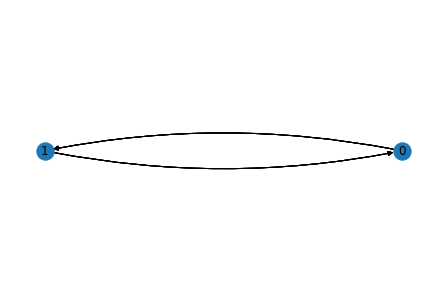

In [17]:
graph = nx.from_numpy_matrix(adj_matrix, parallel_edges=True, create_using=nx.MultiDiGraph)
adj_matrix_multi = np.maximum(np.copy(adj_matrix)-1,0)
pos=nx.circular_layout(graph)
nx.draw(graph, pos=pos, with_labels=True, connectionstyle='arc3, rad = 0.1')

In [18]:
def expand_graph(adj_matrix):
    replicas_structure = dict()
    adj_matrix_exp = np.copy(adj_matrix)
    
    #more multiedges, we have to expand
    while np.sum(adj_matrix_exp>1)>0:
        
        adj_matrix_multi = np.maximum(adj_matrix_exp-1,0)
        edges_out = np.sum(adj_matrix_multi, axis=1)
        node_max = np.argmax(edges_out)
        replicas = np.max(adj_matrix_multi[node_max,:])
        appended_column = np.copy(adj_matrix_exp[:,node_max])
        appended_column[node_max]=1
        for i in range(replicas):
            adj_matrix_exp = np.c_[adj_matrix_exp,appended_column]

        row=np.copy(adj_matrix_exp[node_max,:])

        appended_row = np.minimum(1,row)
        adj_matrix_exp[node_max,:] = appended_row
        row = np.maximum(0,row-1)
        for i in range(replicas):
            appended_row = np.minimum(1,row)
            adj_matrix_exp = np.r_[adj_matrix_exp, [appended_row]]
            row = np.maximum(0,row-1)
        
        replicas_structure[node_max] = [node_max] +  list(range(adj_matrix_exp.shape[0]-replicas, adj_matrix_exp.shape[0]))
        
    return adj_matrix_exp, replicas_structure

{0: [0, 2, 3, 4, 5], 1: [1, 6, 7, 8, 9]}


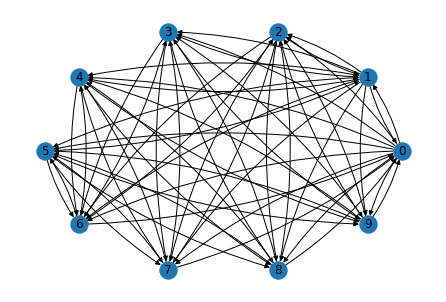

In [19]:
adj_matrix_exp, replicas = expand_graph(adj_matrix)
graph_exp = nx.from_numpy_matrix(adj_matrix_exp, parallel_edges=True, create_using=nx.MultiDiGraph)
pos=nx.circular_layout(graph_exp)
nx.draw(graph_exp, pos=pos, with_labels=True, connectionstyle='arc3, rad = 0.1')
print(replicas)

In [20]:
n_expanded = adj_matrix_exp.shape[0]
matches_handled = np.zeros([len(np.unique(cluster)),len(np.unique(cluster))], dtype=int)
Z = np.eye(3*n_expanded, 3*n_expanded)
for couple in patch_graph:
    i=couple[0]
    j=couple[1]
    for k in range(len(replicas[i])):
        if (k>=len(patch_graph[couple])):
            break
        h = patch_graph[couple][k]
        if j in replicas:
            for w in replicas[j]:
                Z[3*w:3*(w+1), 3*replicas[i][k]:3*(replicas[i][k]+1)] = h
        else:
            Z[3*j:3*(j+1), 3*replicas[i][k]:3*(replicas[i][k]+1)] = h
for replica in replicas:
    r = replicas[replica]
    for k in r:
        Z[3*k:3*(k+1), 3*r[0]:3*(r[0]+1)] = np.eye(3)
        

In [21]:
testing_adj = np.zeros([n_expanded, n_expanded], dtype=int)
for i in range(n_expanded):
    for j in range(n_expanded):
        if not (Z[3*j:3*(j+1), 3*i:3*(i+1)]==np.zeros([3,3])).all():
            testing_adj[i,j] = 1
print((testing_adj==adj_matrix_exp+np.eye(n_expanded, dtype=int)).all())


True


In [22]:
n = len(np.unique(cluster))

In [23]:
C = np.zeros([3*n_expanded, 3*(n_expanded-n)],dtype=int)
for replica in replicas:
    r = replicas[replica]
    first = r[0]
    for k in r:
        if k != first:
            C[3*first:3*(first+1), 3*(k-n):3*(k-n+1)] = np.eye(3)
            C[3*k:3*(k+1), 3*(k-n):3*(k-n+1)] = -np.eye(3)
print(C)

[[ 1  0  0  1  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  1  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  1  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  1  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  1  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  1  0  0  1]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1

In [24]:
#Computation of gamma and zeta for each pair of images

D = np.diag(np.sum(adj_matrix_exp + np.eye(n_expanded), axis=1))
D_kron = np.kron(D, np.eye(3))
M = Z - D_kron

In [25]:
S = (np.eye(M.shape[0])-C@np.linalg.pinv(C))@M.transpose()@M
w,v = np.linalg.eig(S)
w = np.real(w)
v = np.real(v)

In [26]:
d = 3
if C.size == 0:
    off = 0
else:
    off = np.linalg.matrix_rank(C)
indx = np.argsort(w)
indxs = np.array([indx]*indx.shape[0])

In [27]:
w_sort = w[indx]
v_sort = np.take_along_axis(np.real(v), indxs, axis=1)

In [28]:
u_hat = v_sort[:,off:d+off]

In [29]:
u_hat.shape

(30, 3)

In [30]:
U = get_states(u_hat) #Get the state of each node

In [31]:
partial_imgs = [new_matrices[i]["img"] for i in range(n)]

In [32]:
print(type(partial_imgs[0][0][0][0]))

<class 'numpy.uint8'>


In [33]:
_,stitch = stitch_images(U, partial_imgs, 1, n, beautify=True) #Stitch all the images

[1390.471783124313, 3.755329380794592e-14] [1084, 2742]
1.0000208129678314
1.0


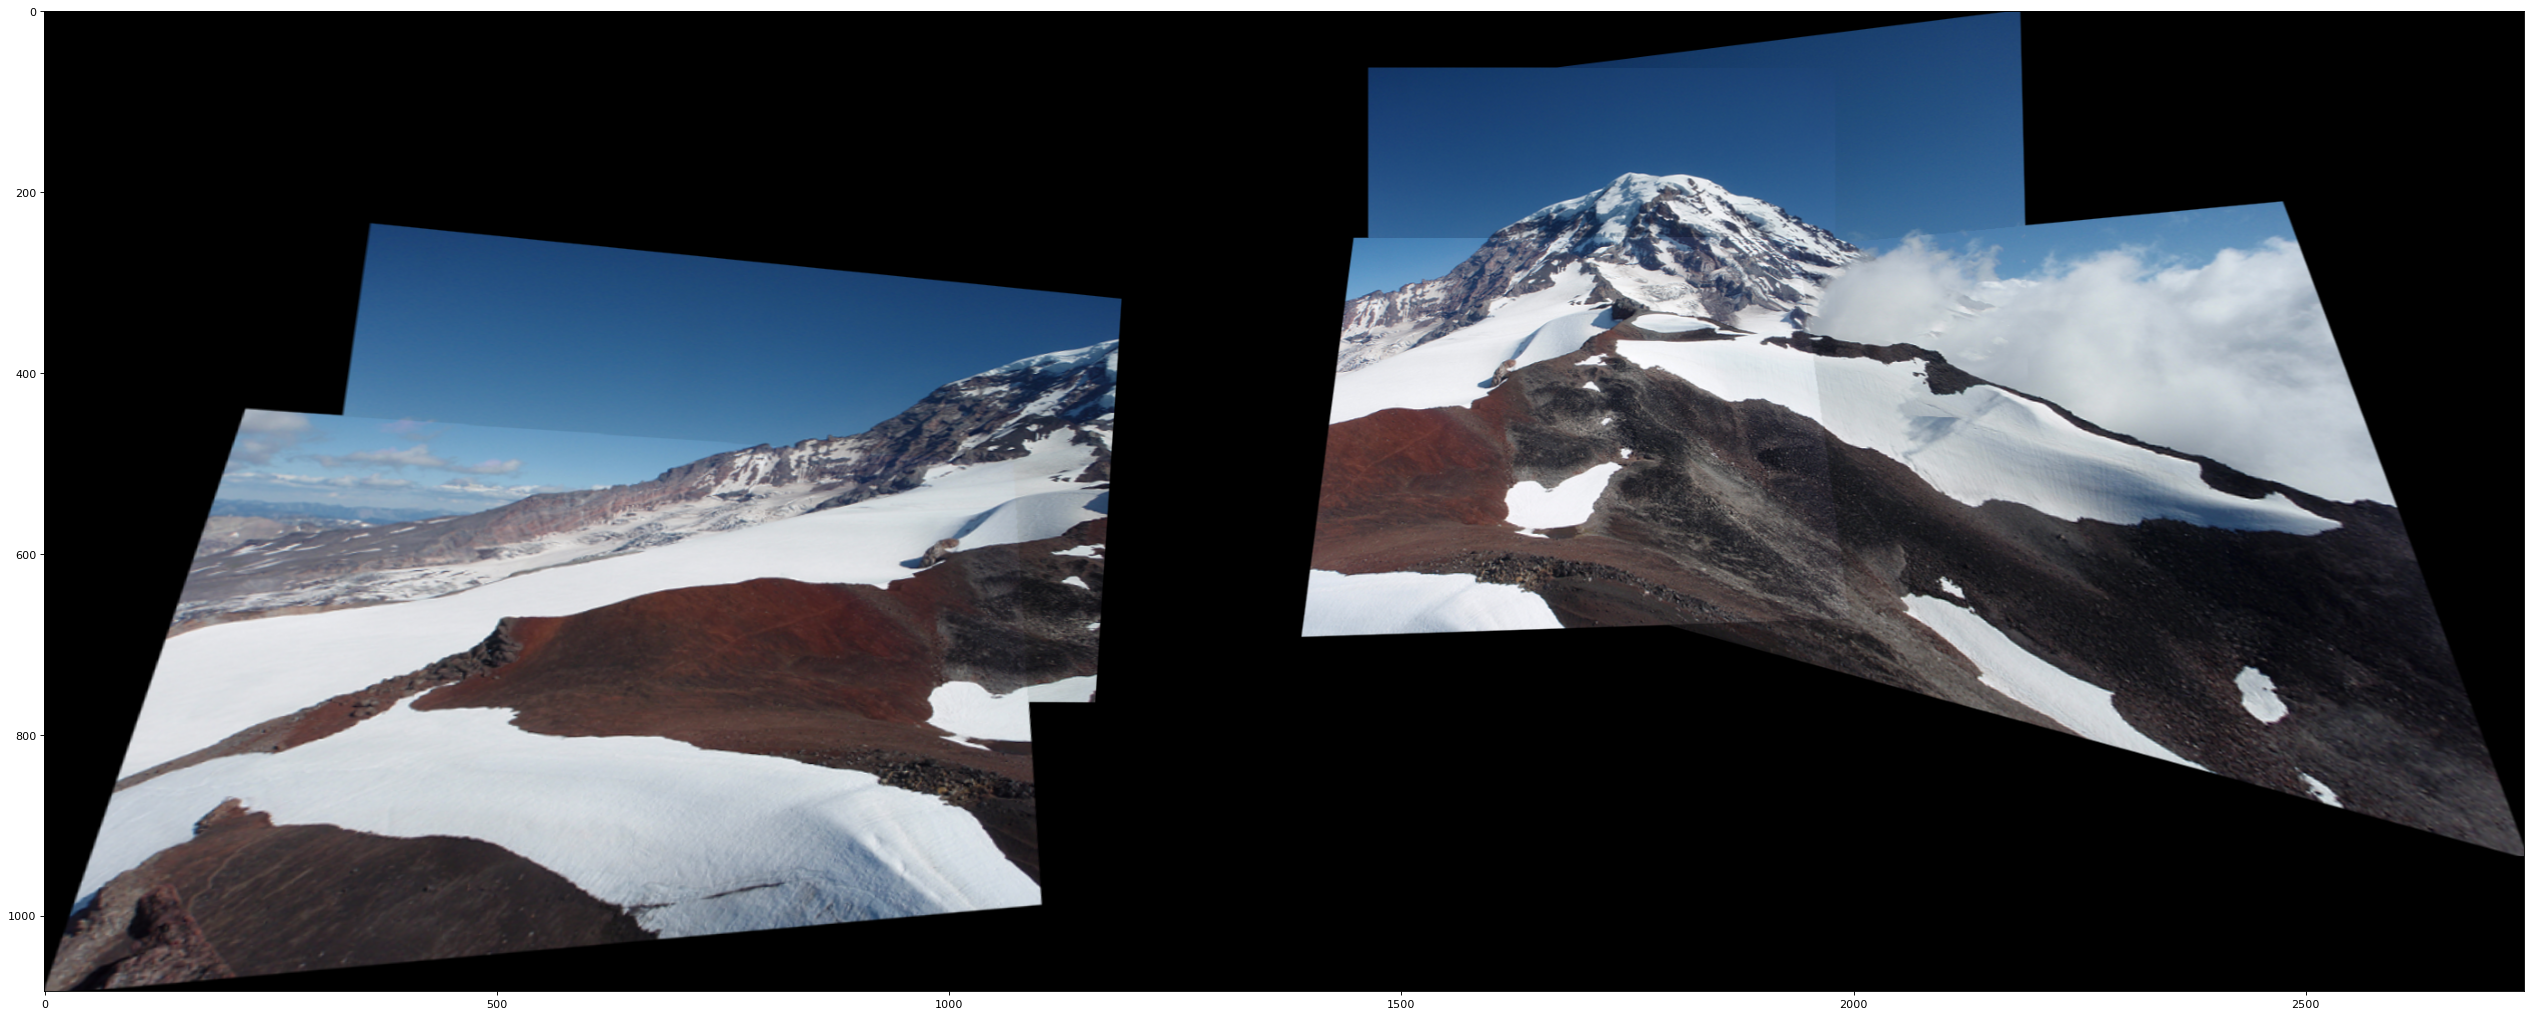

(<matplotlib.image.AxesImage at 0x29105ec4b20>, None)

In [36]:
figure(figsize=(40, 40), dpi=80)
plt.imshow(stitch,),plt.show() #Plot stitched image

In [35]:
i=0
j=5
im1 = imgs[i]
im2 = imgs[j]

rescale = 1./np.max(im1.shape)
T_norm = np.diag([rescale,rescale,1])


h=patch_graph[1,2][1]

small_g = G[(j)*3:(j+1)*3,(i)*3:(i+1)*3]
print(h)
print(small_g)
size = [2000,3000]

img_base = cv.warpPerspective(im1, np.eye(3), size)
img_proj = cv.warpPerspective(im2, np.linalg.inv( np.linalg.inv(T_norm)  @ h @ T_norm), size)
        #plt.imshow(img_proj[:1000,:1000],),plt.show()
stitch = np.maximum(img_base,img_proj)
        
figure(figsize=(40, 40), dpi=80)
plt.imshow(stitch,),plt.show() #Plot stitched image        
        
        #Use maximum as stitch operator (very simple stitching mechanism)
#stitch = np.maximum(im1,img_proj)

KeyError: (1, 2)

In [ ]:
cluster